# Fill evaluation strategy for lime2label

The idea of the fill evaluation strategy is to check how many tokens a model should learn in order to fill the correct label for and entity.

In particular, let be $G_e = \{t_1, t_2, \dots, t_n\}$ the set of **single** tokens that compose the correct label of an entity $e$, without punctuation and stopwords.

Let be $R_m = [t_1, t_2, \dots, t_k]$ the ordered list of the top-$k$ tokens learned by a model $m$. 

We call *check set* of the model $m$ the set $C_m = \{t_i : i \leq z\}$ of the top-$z$ tokens such that $G_e - C_m \equiv \emptyset$.

The performance $\rho_m$ of the model $m$ is calculated as

$$\rho_m = \frac{n + 1}{z + n}$$

Moreover, we account also the *useless* tokens occurrences, that are tokens learned by the model within the check set $C_m$ that are not included in $G_e$.

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import string
from nltk.corpus import stopwords

In [3]:
import matplotlib.pyplot as plt

In [4]:
stw = set(stopwords.words('english'))  

In [5]:
def tokenize(s):
    tokens = []
    for candidate in s.split():
        for c in candidate.split('_'):
            k = "".join([x for x in c if c not in string.punctuation]).lower()
            if k not in stw:
                tokens.append(k)
    return tokens

In [6]:
def get_entities(xlsx):
    return dict([(s, xlsx.parse(s)) for s in xlsx.sheet_names])

In [7]:
def rho(guess, target_tokens):
    t = set(target_tokens)
    n = len(t)
    useless = 0
    for i, trial in enumerate(guess):
        x = set(tokenize(trial))
        r = t.difference(x)
        u = x.difference(t)
        t = r
        useless += len(u)
        if len(t) == 0:
            break
    return n / (i + n), i + 1, useless

def evaluate(data):
    out = {}
    for eid, e in data.items():
        target = tokenize(e.target.values[0])
        models = [x for x in e.columns if x != 'target']
        for model in models:
            r, i, u = rho(e[model], target)
            out[(eid, model)] = {'rho': r, 'trials': i, 'useless': u}
    return pd.DataFrame(out).T

## Glove

### Alaska

In [8]:
alaska_xl = pd.ExcelFile('https://island.ricerca.di.unimi.it/~alfio/shared/lime2label/top_n_alaska.xlsx')
wiki_xl = pd.ExcelFile('https://island.ricerca.di.unimi.it/~alfio/shared/lime2label/top_n_wikidata_v2.xlsx')

In [9]:
alaska_entities = get_entities(alaska_xl)
alaska = evaluate(alaska_entities)
alaska.head(6)

rho  trials  useless
ENTITY#101 lime_term      0.714286     3.0     10.0
           baseline_term  0.833333     2.0      0.0
ENTITY#102 lime_term      0.714286     3.0      0.0
           baseline_term  0.714286     3.0      0.0
ENTITY#16  lime_term      1.000000     1.0      0.0
           baseline_term  1.000000     1.0      0.0

In [10]:
lime = alaska.loc[pd.IndexSlice[:, 'lime_term'], :]
baseline = alaska.loc[pd.IndexSlice[:, 'baseline_term'], :]

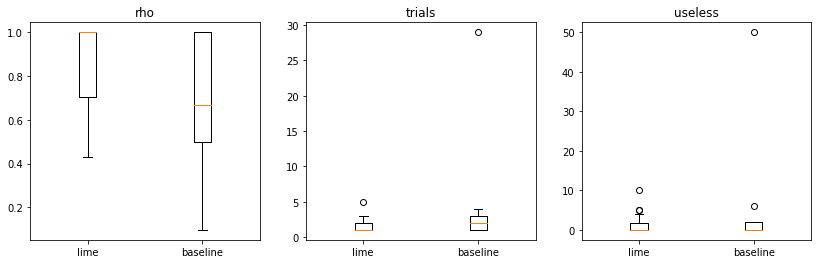

In [11]:
avg = {'lime': {}, 'baseline': {}}
fig, ax = plt.subplots(figsize=(14, 4), ncols=3)
for i, measure in enumerate(['rho', 'trials', 'useless']):
    avg['lime'][measure] = lime[measure].mean()
    avg['baseline'][measure] = baseline[measure].mean()
    ax[i].boxplot([lime[measure], baseline[measure]])
    ax[i].set_xticklabels(['lime', 'baseline'])
    ax[i].set_title(measure)
plt.show()
A = pd.DataFrame(avg).T

In [12]:
A

,rho,trials,useless
lime,0.842857,1.75,1.55
baseline,0.707220,3.55,3.35


### Wikidata

In [13]:
wiki_entities = get_entities(wiki_xl)
wiki = evaluate(wiki_entities)
wiki.head()

rho  trials  useless
Q1005682 lime_term      0.500000     8.0      1.0
         baseline_term  0.538462     7.0      0.0
Q10123   lime_term      0.250000    16.0     18.0
         baseline_term  0.357143    10.0      5.0
Q10127   lime_term      0.500000     6.0      4.0

In [14]:
lime = wiki.loc[pd.IndexSlice[:, 'lime_term'], :]
baseline = wiki.loc[pd.IndexSlice[:, 'baseline_term'], :]

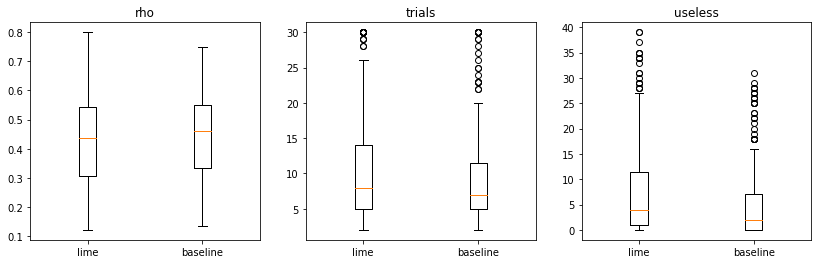

In [15]:
avg = {'lime': {}, 'baseline': {}}
fig, ax = plt.subplots(figsize=(14, 4), ncols=3)
for i, measure in enumerate(['rho', 'trials', 'useless']):
    avg['lime'][measure] = lime[measure].mean()
    avg['baseline'][measure] = baseline[measure].mean()
    ax[i].boxplot([lime[measure], baseline[measure]])
    ax[i].set_xticklabels(['lime', 'baseline'])
    ax[i].set_title(measure)
plt.show()
A = pd.DataFrame(avg).T

In [16]:
A

,rho,trials,useless
lime,0.422232,10.800000,8.456410
baseline,0.437152,9.784615,5.964103


## Lime TfIdf

### Alaska

In [17]:
alaska_xl = pd.ExcelFile('https://island.ricerca.di.unimi.it/~alfio/shared/lime2label/top_n_alaska_tfidf.xlsx')
wiki_xl = pd.ExcelFile('https://island.ricerca.di.unimi.it/~alfio/shared/lime2label/top_n_wikidata_tfidf_v2.xlsx')

In [18]:
alaska_entities = get_entities(alaska_xl)
alaska = evaluate(alaska_entities)
alaska.head(6)

rho  trials  useless
ENTITY#101 lime_term      0.625000     4.0     21.0
           baseline_term  0.833333     2.0      0.0
ENTITY#102 lime_term      0.416667     8.0     22.0
           baseline_term  0.714286     3.0      0.0
ENTITY#16  lime_term      1.000000     1.0      0.0
           baseline_term  1.000000     1.0      0.0

In [19]:
lime = alaska.loc[pd.IndexSlice[:, 'lime_term'], :]
baseline = alaska.loc[pd.IndexSlice[:, 'baseline_term'], :]

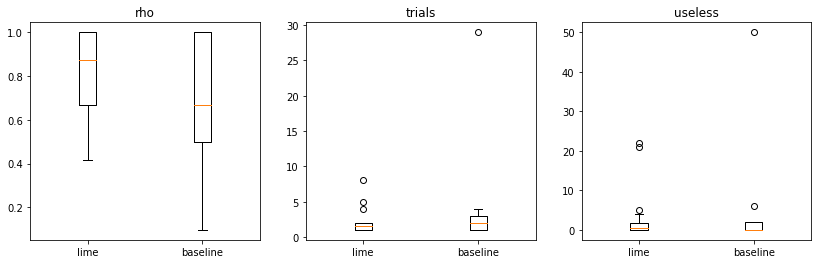

In [20]:
avg = {'lime': {}, 'baseline': {}}
fig, ax = plt.subplots(figsize=(14, 4), ncols=3)
for i, measure in enumerate(['rho', 'trials', 'useless']):
    avg['lime'][measure] = lime[measure].mean()
    avg['baseline'][measure] = baseline[measure].mean()
    ax[i].boxplot([lime[measure], baseline[measure]])
    ax[i].set_xticklabels(['lime', 'baseline'])
    ax[i].set_title(measure)
plt.show()
A = pd.DataFrame(avg).T

In [21]:
A

,rho,trials,useless
lime,0.815179,2.05,3.05
baseline,0.707220,3.55,3.35


### Wiki